<a href="https://colab.research.google.com/github/ShotaArima/task-wind-to-ep/blob/%233/Final_Task(iwano_ver).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 目標
横浜キャンパスの車両門付記に設置されている2機の風車の「合計の発電量」を、「風速」などの情報からニューラルネットワークを利用して予測（推定）する

## 使用データ
- 2023年2月28日～5月30日のうち，風車を稼働させていた
  - 55日分の実測データを利用各日8回（11:00, 12:00, ..., 18:00時点）の観
  - データを利用合計55日×8回＝440個のサンプル

### 説明
- `wind_data_s.csv` では、風速のみのデータ
  - no. 0～303 が4月までの38日分のデータ（学習に使用）
  - no. 304～439 が5月の17日分のデータ（評価に使用）
  - 変数
    - `x1` :その時刻の風速（m/s）
    - `x2` :1時間前の風速（m/s）
    - `y` : 発電量（W）

- `wind_data_sd.csv` では風向きの情報を追加
  - 変数
    - `x3`:その時刻の風向き（度）
    - `x4`:1時間前の風向き（度）

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
# モジュールのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.api.models import Sequential
from keras.api.layers import Dense
from sklearn.preprocessing import MinMaxScaler

In [44]:
# データの読み込み1
# f1 = open('/content/drive/MyDrive/class/知能科学/wind_data_s.csv')
# df1 = pd.read_csv(f1)
f = open('/content/drive/MyDrive/class/知能科学/wind_data_sd.csv')
df = pd.read_csv(f)
df.head()

,no,x1,x2,x3,x4,y
0,0.0,1.9,0.7,225.0,238.0,1.0
1,1.0,2.9,1.9,228.0,225.0,22.0
2,2.0,3.7,2.9,232.0,228.0,47.0
3,3.0,3.4,3.7,224.0,232.0,28.0
4,4.0,2.8,3.4,174.0,224.0,3.0


In [45]:
xy = df.loc[:,['x1', 'x2', 'x3', 'x4', 'y']].values

In [50]:
# データの正規化
scaler = MinMaxScaler()
norm_xy = scaler.fit_transform(xy)
#print(norm_xy)

# 学習データと評価データの準備
norm_x = norm_xy[:, 0:4]
norm_y = norm_xy[:, 4]
x_train = norm_x[:304]
x_test = norm_x[304:440]
y_train = norm_y[:304]
y_test = norm_y[304:440]
#print(x_train)
#print(x_train.shape)
#print(y_train)
#print(y_train.shape)
#print(x_test)
#print(x_test.shape)
#print(y_test)
#print(y_test.shape)

## ニューラルネットワークの構築

In [51]:
# ニューラルネットワークの構築
input_nnode = 4    # 入力層のノード数
mid1_nnode = 8     # １番目の中間層のノード数
mid2_nnode = 4    # ２番目の中間層のノード数
output_nnode = 1   # 出力層のノード数
model = Sequential()
model.add(Dense(mid1_nnode, activation='relu', input_dim=input_nnode))
model.add(Dense(mid2_nnode, activation='relu'))
model.add(Dense(output_nnode, activation='linear'))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_19 (Dense)                │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81 (324.00 B)

 Trainable params: 81 (324.00 B)

 Non-trainable params: 0 (0.00 B)

## 最適化
- 最適化アルゴリズム: Adam
- 損失関数: 平均二乗誤差（mean_squared_error）を利用
  - 平均絶対誤差（mean_absolute_error）は参考のために表示ミニバッチ最適化を利用
- バッチサイズ: 8
- エポック数: 300

In [52]:
# ネットワークの最適化（学習）
model.compile(optimizer='adam',
   loss='mean_squared_error',
   metrics=['mean_absolute_error'])

train_history = model.fit(x_train, y_train,
   batch_size=8,
   epochs=300,
   verbose=1,
   validation_data=(x_test, y_test))

Epoch 1/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0971 - mean_absolute_error: 0.2319 - val_loss: 0.0100 - val_mean_absolute_error: 0.0765
Epoch 2/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0357 - mean_absolute_error: 0.1229 - val_loss: 0.0085 - val_mean_absolute_error: 0.0709
Epoch 3/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0252 - mean_absolute_error: 0.1024 - val_loss: 0.0077 - val_mean_absolute_error: 0.0625
Epoch 4/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0332 - mean_absolute_error: 0.1070 - val_loss: 0.0081 - val_mean_absolute_error: 0.0670
Epoch 5/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0235 - mean_absolute_error: 0.0937 - val_loss: 0.0081 - val_mean_absolute_error: 0.0674
Epoch 6/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0213 - mean_absolute_error: 0.0948 - val_loss: 0.0079 - val_mean_absolute_error: 0.0672
Epoch 7/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0173 - mean_absolute_error: 0.0907 - val_loss

## 結果の表示

{'loss': [0.06562244892120361, 0.031679846346378326, 0.026505177840590477, 0.023076750338077545, 0.020890582352876663, 0.019585074856877327, 0.018457647413015366, 0.017446395009756088, 0.016476059332489967, 0.015590010210871696, 0.014821167103946209, 0.014143168926239014, 0.01348824892193079, 0.012820860370993614, 0.012246114201843739, 0.011744343675673008, 0.01130357850342989, 0.010749829933047295, 0.01049677561968565, 0.00995352678000927, 0.009788482449948788, 0.009151839651167393, 0.009074737317860126, 0.008731827139854431, 0.008834532462060452, 0.008582388050854206, 0.008424702100455761, 0.008253288455307484, 0.008357075974345207, 0.008182000368833542, 0.008008494973182678, 0.007953830063343048, 0.008019810542464256, 0.007641944568604231, 0.007672408130019903, 0.007760845590382814, 0.007419445086270571, 0.00732510257512331, 0.0072421119548380375, 0.007125732023268938, 0.007264598272740841, 0.0071272701025009155, 0.006815311964601278, 0.006827103439718485, 0.006855769548565149, 0.00

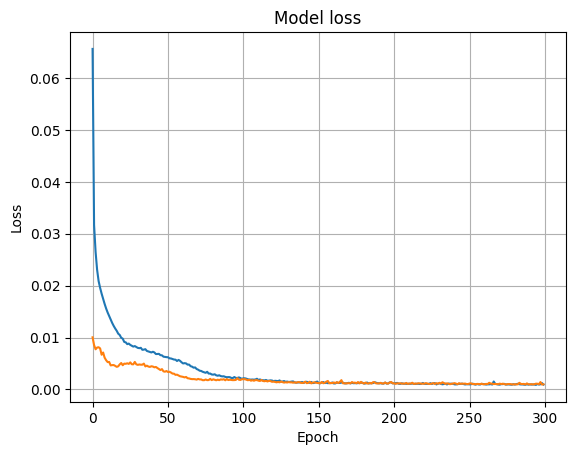

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
[114. 126. 160. 174. 177. 157.  88.  82. 110. 111. 161. 135. 150. 170.
 167. 190. 110. 174. 223. 234. 226. 238. 200. 249. 225. 227. 230. 225.
 162. 119. 126. 249. 133. 231. 232. 237. 238. 247. 239. 251. 145.  89.
 105.  82.  86.  77.  71.  66. 132. 103. 136. 225. 208. 229. 223. 238.
 238. 242. 234. 186. 236. 243. 240. 259. 224. 233. 239. 239. 245. 246.
 237. 252. 253. 250. 250. 248. 238. 151. 219. 246. 111. 150. 203. 218.
 206. 236. 221. 230.  80.  90.  72.  81.  76.  77.  80.  73. 115. 109.
  90. 101.  96. 141. 141.  91. 207. 234. 238. 233. 238. 242. 234. 243.
 238. 239. 248. 241. 222. 236. 248. 252.  65.  66.  66.  73.  59.  91.
  49.  11. 251. 252. 244. 231. 246. 238. 245. 238.]
[114. 126. 160. 174. 177. 157.  88.  82. 110. 111. 161. 135. 150. 170.
 167. 190. 110. 174. 223. 234. 226. 238. 200. 249. 225. 227. 230. 225.
 162. 119. 126. 249. 133. 231. 232. 237. 238. 247. 239. 251. 145.  89.
 105.  82.  86.  77.  71.  66. 132. 103. 136. 225. 208. 22

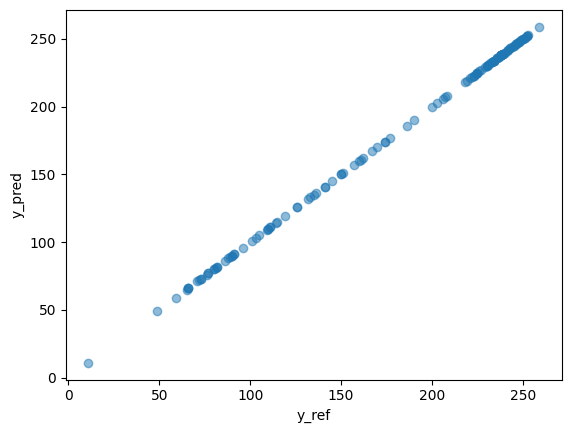

In [53]:
# 学習経過の表示
train_history.history.keys()
print(train_history.history)
len(train_history.history['loss'])

# 損失関数値のプロット
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid()
plt.show()

# 評価データによる推定と逆正規化
norm_y_pred = model.predict(x_test)
#print(norm_y_pred)
norm_xy_pred = np.hstack((x_test, norm_y_pred))
xy_pred = scaler.inverse_transform(norm_xy_pred)

# 最終的な推定値と正解値の表示
y_pred = xy_pred[:, 2]
y_ref = xy[304:440, 2]
print(y_pred)
print(y_ref)
fig, ax = plt.subplots()
ax.scatter(y_ref, y_pred, alpha=0.5)
ax.set_xlabel('y_ref')
ax.set_ylabel('y_pred')
plt.show()